# Variant distribtion per chromosome

This notebook aims to understand the distribution of variantIndex and credibleSet dataset variants across chromosomes.
VariantIndex contains variants that have well known associations to traits or come from GWAS credible sets

In [1]:
# Ensure proper java version < 11
!java -version


openjdk version "11.0.13" 2021-10-19
OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21)
OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)


In [35]:
!rsync -rpltvz --delete rsync.ebi.ac.uk::pub/databases/opentargets/platform/25.03/output/variant ../../data/.
!rsync -rpltvz --delete rsync.ebi.ac.uk::pub/databases/opentargets/platform/25.03/output/credible_set ../../data/.


receiving incremental file list

sent 29 bytes  received 1.771 bytes  3.600,00 bytes/sec
total size is 3.060.963.047  speedup is 1.700.535,03
receiving incremental file list

sent 29 bytes  received 1.770 bytes  3.598,00 bytes/sec
total size is 2.371.305.976  speedup is 1.318.124,50


In [ ]:
import seaborn as sns
from gentropy.common.session import Session
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.variant_index import VariantIndex
from pyspark.sql import Column
from pyspark.sql import functions as f


In [36]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
variant_index_path = "../../data/variant"
credible_set_path = "../../data/credible_set"


In [5]:
session.spark


In [38]:
vi = VariantIndex.from_parquet(session, variant_index_path)
cs = StudyLocus.from_parquet(session, credible_set_path)


In [26]:
chromosomes = [str(c) for c in range(1, 23)] + ["X", "Y", "MT"]
order = {c: idx for idx, c in enumerate(chromosomes)}


def sort_by_chromosome(col: Column) -> Column:
    """Sort by chromosome."""
    expr = f.when(f.lit(False), None)
    for chromosome_name, chromosome_index in order.items():
        expr = expr.when(col == chromosome_name, f.lit(chromosome_index))
    return expr.alias("chromosomeIndex")


In [ ]:
vi_chromosome_variants = (
    vi.df.groupBy("chromosome")
    .count()
    .withColumn("chromosomeIndex", sort_by_chromosome(f.col("chromosome")))
    .orderBy("chromosomeIndex")
)
cs_chromosome_variants = (
    cs.df.groupBy("chromosome").
    .count()
    .withColumn("chromosomeIndex", sort_by_chromosome(f.col("chromosome")))
    .orderBy("chromosomeIndex")
)


In [ ]:
chromosome_variants.show(truncate=False, n=30)


+----------+------+---------------+
|chromosome|count |chromosomeIndex|
+----------+------+---------------+
|1         |555116|0              |
|2         |574342|1              |
|3         |410428|2              |
|4         |334152|3              |
|5         |367694|4              |
|6         |344861|5              |
|7         |361729|6              |
|8         |276396|7              |
|9         |263790|8              |
|10        |287524|9              |
|11        |356345|10             |
|12        |316971|11             |
|13        |163224|12             |
|14        |213421|13             |
|15        |214971|14             |
|16        |262910|15             |
|17        |299994|16             |
|18        |126803|17             |
|19        |261633|18             |
|20        |136870|19             |
|21        |72164 |20             |
|22        |119047|21             |
|X         |170748|22             |
|Y         |96    |23             |
|MT        |2653  |24       

In [ ]:
sns.set_style("white")
sns.set_context("paper", font_scale=1.0)
sns.set_palette(sns.color_palette("coolwarm"))


Text(0.5, 1.0, 'Variant counts across chromosomes from VariantIndex')

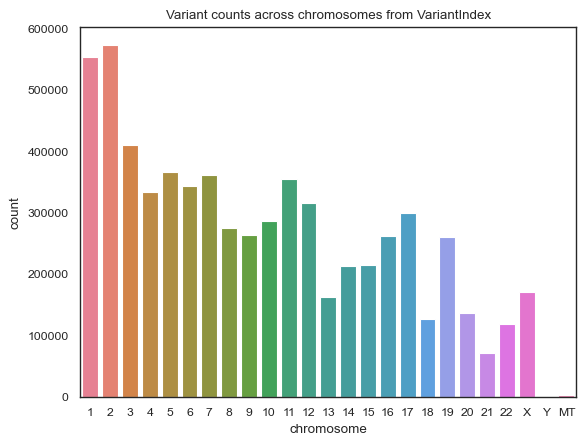

In [ ]:
fig = sns.barplot(chromosome_variants.toPandas(), x="chromosome", y="count")
fig.set_title("Variant counts across chromosomes from VariantIndex")
